# Casing design affects frac geometry and economics
_Ohm Devani_

NOTE: This project will focus on relative economic uplift between 2 casing designs in similar geology.

## Contents
1. Model inputs
2. Base case
    - define per-frac endpoints (min rate defined by dfit initiation rate, max rate defined by hhp of fleet, water volume/frac)
    - economic constants (pump charge, water cost
3. Economic sensitivities
    1. Frac surface area (PKN) vs rate; 2 series for different casing sizes
        - \$ cost/surface area vs rate vs (y-axis 2) surface area
        - Talk about impact of other variables: stress shadow, additional height growth in absence of frac barriers, better proppant/fluid distribution between clusters
    2. Frac pump time vs rate vs $ cost/stage (y2)


### Model parameters

0.7 psi/ft frac gradient
1.0 connate water SG
Horizontal well
Midpoint lateral TVD 10,000 ft

Scenario A:
7" 32# T-95 intermediate casing to 9000 ft (6.094" ID)   
4 1/2" 11.6# P-110 liner to 20000 ft (4" ID)

Scenario B:
5 1/2" 17# P-110 casing to 20000 ft (4.892" ID)

60 bbl/ft
ignore proppant
7000 psi target surface pressure
2000 psi target NWB friction


### Pipe friction estimates

Hazen-Williams for pipe friction
SPE 146674 correlation and adjustment for friction reduction

In [3]:
def hwfriclosspsi(cfactor,ratebpm,pipeidinch,lengthft):
    hyddiam = 4*(3.14159*(pipeidinch/2)**2)/(2*3.14169*pipeidinch/2)
    hwfriclosspsi = 0.2083*((100/cfactor)**1.852)*((ratebpm*42)**1.852)/(hyddiam**4.8655)*.433*lengthft/100
    return hwfriclosspsi

def freduction(pipeidinch,ratebpm):
    velocftpersec = (5.615*144/60)*ratebpm/(3.14159*(pipeidinch/2)**2)
    fr = 6.2126*velocftpersec**0.5858
    if fr<25:
        fr=25
    elif fr>85:
        fr=85
    return fr

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


bpmrange=list(range(0, 150))
adjfac=0.1
#sceAfric = [hwfriclosspsi(120,i,6.094,9000)*(1-freduction(6.094,i)/100)*adjfac+hwfriclosspsi(120,i,4,11000)*(1-freduction(4,i)/100)*adjfac for i in bpmrange]
#sceBfric = [hwfriclosspsi(120,i,4.892,20000)*(1-freduction(4.892,i)/100)*adjfac for i in bpmrange]

sceAfric = [hwfriclosspsi(120,i,6.094,9000)*adjfac+hwfriclosspsi(120,i,4,11000)*adjfac for i in bpmrange]
sceBfric = [hwfriclosspsi(120,i,4.892,20000)*adjfac for i in bpmrange]

NameError: name 'hwfriclosspsi' is not defined

### BHTP & Net Fracture Pressure
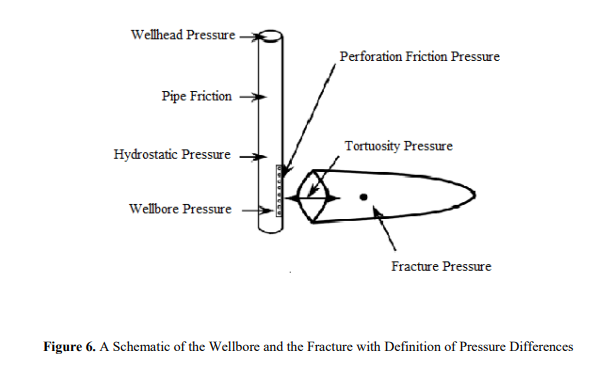

Ozesen, Ahsen. ANALYSIS OF INSTANTANEOUS SHUT-IN PRESSURE IN SHALE OIL AND GAS RESERVOIRS. 2017. Penn State U, Masters Thesis. https://etda.libraries.psu.edu/files/final_submissions/15314.

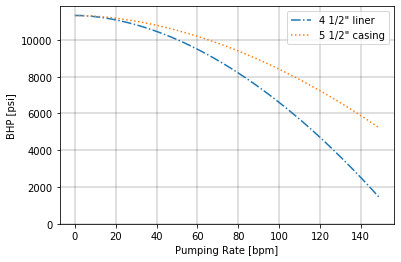

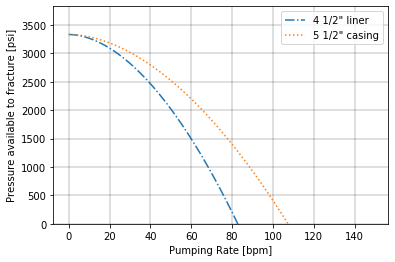

In [85]:
surfpress=7000
tvd=10000
nwbfriction=1000
fracgradient=0.70

def nfp(bhtp,nwbfric,fracgrad,tvd):
    nfp = bhtp-nwbfric-fracgrad*tvd
    return nfp


bhtpA = [surfpress-i+0.433*tvd for i in sceAfric]
bhtpB = [surfpress-i+0.433*tvd for i in sceBfric]

nfpA = [nfp(i,nwbfriction,fracgradient,tvd) for i in bhtpA]
nfpB = [nfp(i,nwbfriction,fracgradient,tvd) for i in bhtpB]


plt.plot(bpmrange, bhtpA, label = "4 1/2\" liner", linestyle="-.")
plt.plot(bpmrange, bhtpB, label = "5 1/2\" casing", linestyle=":")
plt.ylim(bottom=0)
plt.grid(color='k', linestyle='-', linewidth=0.25)

plt.xlabel('Pumping Rate [bpm]')
plt.ylabel('BHP [psi]')

plt.legend()
plt.show()


plt.plot(bpmrange, nfpA, label = "4 1/2\" liner", linestyle="-.")
plt.plot(bpmrange, nfpB, label = "5 1/2\" casing", linestyle=":")
plt.ylim(bottom=0)
plt.grid(color='k', linestyle='-', linewidth=0.25)

plt.xlabel('Pumping Rate [bpm]')
plt.ylabel('Pressure available to fracture [psi]')

plt.legend()
plt.show()

#print(nfpA)
#print(nfpB)
#print(nfpA.index(57.58718507850335))
#print(nfpB.index(21.654318992093977))

Under these constraints, the 5 1/2" casing designs supports a maximum pump rate of 107 bpm, which is 25 bpm higher than the 4 1/2" liner design's max pump rate of 82 bpm.   

Below, I calculate the time and cost savings from this added rate over a range of pumped volumes.
HHP (hp) = Surface Treating Pressure (psi) x Rate (bpm) / 40.8
Indicative pricing estimates for a 45,000 hhp frac spread, and typical pricing are $6-8,000/hr.

Plot below shows a typical frac spread will have more HHP than is required at even the highest rate.

https://www.danielep.com/news-observations/3-14-21-dep-industry-observations-frac-engine-supply-frac-newbuilds-sand-thoughts-and-q4-earnings/
https://markets.businessinsider.com/news/stocks/fracking-fluid-end-market-size-to-reach-us-678-million-in-2025-says-stratview-research-1029144444

In [48]:
def hhp(stp,rate):
    hhp=stp*rate/40.8
    return hhp

plt.plot(bpmrange, [hhp(surfpress,i) for i in bpmrange], label = "Required HHP")
plt.ylim(bottom=0, top=50000)
plt.axhline(y=45000, color='r', linestyle='--', label = "Available HHP")
plt.grid(color='k', linestyle='-', linewidth=0.25)

plt.xlabel('Pumping Rate [bpm]')
plt.ylabel('HHP required')
plt.legend()
plt.show()

NameError: name 'surfpress' is not defined

For simplicity, I'm only considering the hourly pumping cost and neglecting other costs like diesel.

The plot below shows pumping cost vs total volume for the two casing designs pumping at max rates which retain a few hundred psi of net frac pressure (80 vs 105).

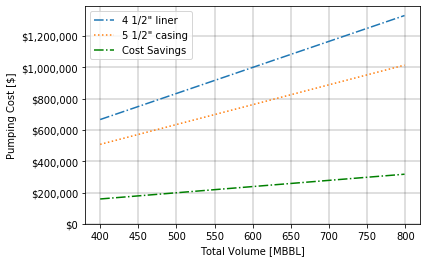

In [51]:
volumerange=list(range(400, 800))
pumpcost=8000 #$8000/hr
amaxrate=80
bmaxrate=105

acost=[pumpcost*1000*i/(amaxrate*60) for i in volumerange]
bcost=[pumpcost*1000*i/(bmaxrate*60) for i in volumerange]

fig, ax = plt.subplots()
ax.plot(volumerange,acost, label = "4 1/2\" liner", linestyle="-.")
ax.plot(volumerange,bcost, label = "5 1/2\" casing", linestyle=":")
ax.plot(volumerange, [a_i - b_i for a_i, b_i in zip(acost, bcost)], label = "Cost Savings", linestyle="-.", color='g')

plt.ylim(bottom=0)
ax.grid(color='k', linestyle='-', linewidth=0.25)

plt.xlabel('Total Volume [MBBL]')
plt.ylabel('Pumping Cost [$]')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()


### Economic sensitivities
5 1/2" max rate is approx. 30% greater than 4 1/2" liner's max rate.
Fracture surface area as a function of rate is a convolved problem requiring a simulator; I suppose a range of 0%-15% oil IP30 uplift for the range of 105-80bpm, respectively.

Economic variables:
- 75% NRI
- $50 flat net oil price
- Harmonic decline
- 800 MBBL water pumped

Production for 4 1/2" scenario:   
- 800 bopd IP (24.3 MBO/mo)
- 800 MBO EUR over 30 years
- Ignoring water, gas

Production for 5 1/2" scenario:   
- Variable IP
- 800 MBO EUR over 30 years
- Ignoring water, gas

In [30]:
import numpy as np
#from sympy.solvers import solve
#from sympy import Symbol
from sympy import log

#def solvedi(np,qi,t):
#    di = Symbol('di',real=True)
#    solvedi=solve(np/log(qi/(qi/(1+di*t)))-(qi/di),di)
#    return solvedi

#adeclinerate_monthly = solvedi(800000,36500,360)
#print(N(adeclinerate_monthly[0]))

#print(N(solvedi(1000000,30000,600)))

ip=800
eur=800000
months=360

def brutedi(np,qi,t):
    calcerror=-1
    di=0.01
    while calcerror<0:
        calcerror=np-((qi/di)*log(qi/(qi/(1+di*t))))
        if calcerror>0:
            break
        else:
            di=di+0.0001
    #print(di)
    return di

#adeclinerate_monthly = brutedi(800000,36500,360)

ipuplift=np.linspace(0,0.15,num=16)
col2=(ipuplift+1)*ip
col3=np.zeros(col2.size)

i=0
while i<col2.size:
    col3[i]=brutedi(eur,col2[i]*30.4,months)
    i+=1

#print(col2)
#print(col3)

In [28]:
def harmonictotal(qi,di,t):
    harmonictotal=((qi/di)*log(qi/(qi/(1+di*t))))
    return harmonictotal
    
def pv30yr(netoilprice,nri,ip,initd,discrate):
    cumarray=np.zeros(360)
    casharray=np.zeros(360)
    ipmonth=ip*30.4
    discratemonth=discrate/12
    j=0
    while j<casharray.size:
        if j==0:
            cumarray[j]=harmonictotal(ipmonth,initd,1)
            casharray[j]=cumarray[j]*netoilprice*nri
        else:
            cumarray[j]=harmonictotal(ipmonth,initd,j+1)
            casharray[j]=(cumarray[j]-cumarray[j-1])*netoilprice*nri
        j+=1
    #print(cumarray)
    #print(casharray)
    #print(cumarray[cumarray.size-1])
    pv30yr=np.npv(discratemonth,casharray)
    return pv30yr

In [39]:
netprice=50
netri=0.75
discountrate=0.10
totalpumpedvolume=800000

#print(pv30yr(netprice,netri,920,.137,0))
col4=np.zeros(col2.size)
colincpv=np.zeros(col2.size)

i=0
while i<col4.size:
    col4[i]=pv30yr(netprice,netri,col2[i],col3[i],discountrate)
    i+=1

i=0
while i<colincpv.size:
    colincpv[i]=col4[i]-col4[0]
    i+=1
#print(colincpv)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: numpy.npv is deprecated and will be removed from NumPy 1.20. Use numpy_financial.npv instead (https://pypi.org/project/numpy-financial/).


In [44]:
pumpratearray=np.linspace(105,80,num=16)
pumpsavings=np.zeros(pumpratearray.size)

i=0
while i<pumpsavings.size:
    if pumpratearray[i] == amaxrate:
        pumpsavings[i]=0
    else:
        pumpsavings[i]=pumpcost*(-(totalpumpedvolume/(pumpratearray[i]*60))+(totalpumpedvolume/(amaxrate*60)))
    i+=1

#print(pumpsavings)

[317460.31746032 301075.2688172  284153.00546448 266666.66666667
 248587.57062147 229885.05747126 210526.31578947 190476.19047619
 169696.96969697 148148.14814815 125786.16352201 102564.1025641
  78431.37254902  53333.33333333  27210.88435374      0.        ]


In [64]:
farray = np.column_stack((ipuplift, col2)) #ip bopd
farray = np.column_stack((farray, col3)) #di
farray = np.column_stack((farray, colincpv))
farray = np.column_stack((farray, pumpratearray))
finalarray = np.column_stack((farray, pumpsavings))

#print(finalarray[:,5])

finaldf = pd.DataFrame(finalarray, columns = ['IP_uplift','IP_BOPD','Di_monthly','Acceration_PV','Pump_Rate','Pump_Savings'])
finaldf['Total_PV'] = finaldf['Acceration_PV'] + finaldf['Pump_Savings']

#print(finaldf)

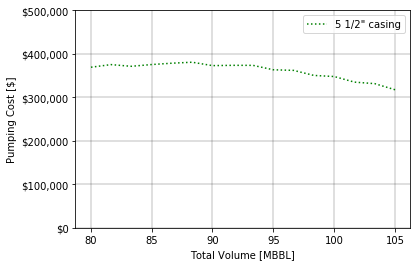

In [67]:
fig, ax = plt.subplots()
ax.plot(finaldf['Pump_Rate'],finaldf['Total_PV'], label = "5 1/2\" casing", linestyle=":", color='g')

plt.ylim(bottom=0, top=500000)
ax.grid(color='k', linestyle='-', linewidth=0.25)

plt.xlabel('Total Volume [MBBL]')
plt.ylabel('Pumping Cost [$]')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()